In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import cv2
import random
import os


In [26]:
TRAIN_DIR = 'ZhangLabData/CellData/chest_xray/train'
TEST_DIR = 'ZhangLabData/CellData/chest_xray/test'
categories = ['NORMAL', 'PNEUMONIA']

In [27]:
#change the size of the X-ray image for better processing
IMG_SIZE = 224


In [28]:
#lets create training data
train_data = []

#used to assign label to the given train
def assign_label(img):
    label = -1
    type_x = img.split('-')[0]
    
    if type_x == 'NORMAL':
        label = 0
    elif type_x == 'BACTERIA':
        label = 1
    else:
        label = 2
    
    return label

def load_train_data():
    for category in categories:
        path = os.path.join(TRAIN_DIR, category)
        for img in os.listdir(path):
            label = assign_label(img)
            try:
                img_data = cv2.imread(os.path.join(path, img))
                new_data = resize_img(img_data)
                train_data.append([new_data, label])
            except Exception as e:
                print(e)

load_train_data()
random.shuffle(train_data)

In [29]:
test_data = []

def load_test_data():
    for category in categories:
        path = os.path.join(TEST_DIR, category)
        for img in os.listdir(path):
            label = assign_label(img)
            try:
                img_data = cv2.imread(os.path.join(path, img))
                new_data = resize_img(img_data)
                test_data.append([new_data, label])
            except Exception as e:
                print(e)

load_test_data()
random.shuffle(test_data)

OpenCV(4.5.5) D:\bld\libopencv_1654292817370\work\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [30]:
X_train,X_test = [],[]
y_train, y_test = [],[]

def convert2np(data_arr):
    X,y = [],[]
    for data, label in data_arr:
        X.append(data)
        y.append(label)
    
    X = np.array(X).reshape(-1, IMG_SIZE,IMG_SIZE, 3)
    y = np.array(y)
    
    X = X = normalize(X, axis = 1)
        
    return X,y

X_train, y_train = convert2np(train_data)
X_test, y_test = convert2np(test_data)

MemoryError: Unable to allocate 5.87 GiB for an array with shape (5232, 224, 224, 3) and data type float64

In [13]:
# randomize the data before training
def shuffle_data(X,y):
    zipped_train = list(zip(X,y))
    shuffle(zipped_train)
    X, y = zip(*zipped_train)
    return np.array(X),np.array(y)

X_train, y_train = shuffle_data(X_train, y_train)

print(len(X_train))
X_val,y_val = X_train[:520],y_train[:520] 
X_train,y_train = X_train[520:], y_train[520:]

5232


In [14]:
bsize = 64
epochs = 50

aug = ImageDataGenerator(rotation_range=20,	zoom_range=0.3,	vertical_flip=True)
#build model using keras

model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = [SparseCategoricalAccuracy()])

hist = model.fit_generator(aug.flow(X_train,y_train, batch_size = bsize), 
                          steps_per_epoch=len(X_train) // bsize,
                          epochs = epochs,
                          validation_data= (X_val, y_val))

model.save('pneumonia_train.h5')



C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
73/73 [==============================] - 152s 2s/step - loss: 1.0738 - sparse_categorical_accuracy: 0.4877 - val_loss: 0.9605 - val_sparse_categorical_accuracy: 0.5577
Epoch 2/50
73/73 [==============================] - 138s 2s/step - loss: 0.9273 - sparse_categorical_accuracy: 0.5893 - val_loss: 0.9080 - val_sparse_categorical_accuracy: 0.5788
Epoch 3/50
73/73 [==============================] - 115s 2s/step - loss: 0.8705 - sparse_categorical_accuracy: 0.6203 - val_loss: 0.8804 - val_sparse_categorical_accuracy: 0.5942
Epoch 4/50
73/73 [==============================] - 115s 2s/step - loss: 0.8478 - sparse_categorical_accuracy: 0.6269 - val_loss: 0.7776 - val_sparse_categorical_accuracy: 0.6615
Epoch 5/50
73/73 [==============================] - 115s 2s/step - loss: 0.8011 - sparse_categorical_accuracy: 0.6540 - val_loss: 0.7372 - val_sparse_categorical_accuracy: 0.6692
Epoch 6/50
73/73 [==============================] - 116s 2s/step - loss: 0.7513 - sparse_categorical_accu

In [16]:
# model = load_model('best_model.hdf5')
train_acc = model.evaluate(X_train,y_train ,verbose = False)
test_acc = model.evaluate(X_test, y_test, verbose = False)
yhat_classes = model.predict_classes(X_test, verbose=0)

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [17]:
print(f'Training: Accuracy = {train_acc[1]}')
print(f'Test: Accuracy = {test_acc[1]}\n')

print(f'Training: Loss = {train_acc[0]}')
print(f'Test: Loss = {test_acc[0]}\n')


Training: Accuracy = 0.8132427930831909
Test: Accuracy = 0.8782051205635071

Training: Loss = 0.43726131319999695
Test: Loss = 0.4415041506290436



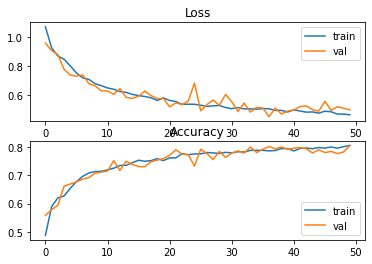

In [18]:
#PLot graphs for loss and accuracy yduring training

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['sparse_categorical_accuracy'], label='train')
plt.plot(hist.history['val_sparse_categorical_accuracy'], label='val')
plt.legend()
plt.show()

Accuracy: 0.878205
Precision: 0.878205
Recall: 0.878205
F1 score: 0.878205
Confusion Matrix:
[[198   9  27]
 [  7 228   7]
 [  3  23 122]]


<AxesSubplot:>

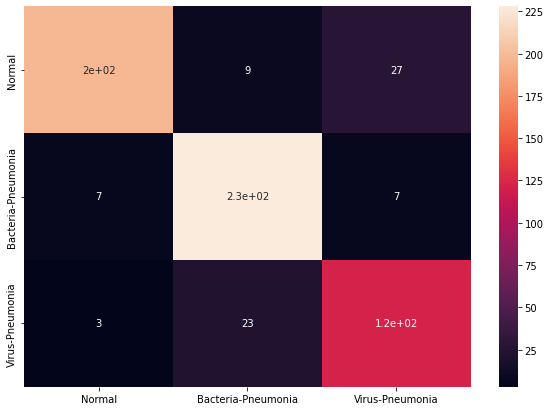

In [19]:
# predict classes for test set

# reduce to 1d array
# yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average = 'micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average = 'micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average = 'micro')
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(f'Confusion Matrix:\n{matrix}')

categories = ['Normal', 'Bacteria-Pneumonia', 'Virus-Pneumonia']
df_cm = pd.DataFrame(matrix, index = [i for i in categories],
                  columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot = True)

In [20]:
model = load_model('pneumonia_train.h5')
model_eval = model.evaluate(X_test, y_test, verbose = 0)

In [21]:
print(model_eval)

[0.4415041506290436, 0.8782051205635071]
